<a href="https://colab.research.google.com/github/mint-aguccim/Machine_Learning_Programming/blob/main/10%EC%A3%BC%EC%B0%A8/CNN%2BLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# -----------------------------------------------------------------
# 1. 데이터 로딩
# -----------------------------------------------------------------
def load_file(filepath):
    dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
    return dataframe.values

In [3]:
def load_group(filenames, prefix=''):
    loaded = list()
    for name in filenames:
        data = load_file(prefix + name)
        loaded.append(data)
    loaded = np.dstack(loaded)
    return loaded

In [4]:
def load_dataset_group(group, prefix=''):
    filepath = prefix + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = load_group(filenames, filepath)
    y = load_file(prefix + group + '/y_'+group+'.txt')
    return X, y

In [5]:
def load_dataset(prefix=''):
    # 경로를 사용자의 Google Drive 경로로 수정했습니다.
    # 이 부분은 환경에 맞게 확인이 필요합니다.
    trainX, trainy = load_dataset_group('train', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/')
    testX, testy = load_dataset_group('test', prefix + '/content/drive/MyDrive/Colab Notebooks/UCI HAR Dataset/')

    trainy = trainy - 1
    testy = testy - 1
    trainy_one_hot = to_categorical(trainy)
    testy_one_hot = to_categorical(testy)
    print(trainX.shape, trainy.shape, trainy_one_hot.shape, testX.shape, testy.shape, testy_one_hot.shape)
    return trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot

In [6]:
# 데이터 로드
# prefix=''를 사용하여 load_dataset 함수 내부에 하드코딩된 경로를 사용합니다.
trainX, trainy, trainy_one_hot, testX, testy, testy_one_hot = load_dataset()

/tmp/ipython-input-917459507.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-917459507.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-917459507.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp/ipython-input-917459507.py:5: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  dataframe = pd.read_csv(filepath, header=None, delim_whitespace=True)
/tmp

(7352, 128, 9) (7352, 1) (7352, 6) (2947, 128, 9) (2947, 1) (2947, 6)


In [7]:
# -----------------------------------------------------------------
# 2. 데이터 분리
# -----------------------------------------------------------------
from sklearn.model_selection import train_test_split

In [8]:
# 훈련 데이터를 훈련/검증 세트로 분리
X_train,X_val,y_train_one_hot,y_val_one_hot,y_train,y_val=train_test_split(trainX, trainy_one_hot, trainy,test_size=0.2,random_state=100)

In [9]:
print(X_train.shape,X_val.shape,y_train_one_hot.shape,y_val_one_hot.shape,y_train.shape,y_val.shape)

(5881, 128, 9) (1471, 128, 9) (5881, 6) (1471, 6) (5881, 1) (1471, 1)


In [10]:
# 모델 입/출력 형태 정의
n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train_one_hot.shape[1]

In [11]:
# -----------------------------------------------------------------
# 3. 모델 정의
# -----------------------------------------------------------------
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dropout, Dense

In [12]:
# Keras Sequential API를 사용한 CNN + LSTM 모델
cnn_lstm_model = Sequential()

In [13]:
# CNN 부분 (특징 추출)
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2))
cnn_lstm_model.add(Dropout(0.2)) # CNN 특징 추출 후 Dropout

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [14]:
# LSTM 부분 (순서 학습)
# CNN의 출력을 LSTM의 입력으로 전달합니다.
# LSTM은 3D 텐서를 입력으로 기대하므로, Conv1D의 출력이 (샘플, 새로운_타임스텝, 필터수) 형태여야 합니다.
# MaxPooling1D 이후의 출력은 (샘플, 줄어든_타임스텝, 필터수) 형태이므로 바로 LSTM에 연결 가능합니다.
cnn_lstm_model.add(LSTM(100, return_sequences=False)) # return_sequences=False는 마지막 타임스텝의 출력만 반환
cnn_lstm_model.add(Dropout(0.5)) # LSTM 특징 추출 후 Dropout

In [15]:
# 분류기를 위한 Dense 레이어
cnn_lstm_model.add(Dense(100, activation='relu'))
cnn_lstm_model.add(Dense(n_outputs, activation='softmax'))

In [16]:
# 모델 컴파일
cnn_lstm_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [17]:
# 모델 요약 출력
cnn_lstm_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 126, 64)        │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 63, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 100)            │        66,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           606 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 78,498 (306.63 KB)

 Trainable params: 78,498 (306.63 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
# -----------------------------------------------------------------
# 4. 모델 훈련
# -----------------------------------------------------------------

# 모델 훈련 (단일 입력, validation_data 사용)
model_history = cnn_lstm_model.fit(
    X_train, y_train_one_hot,  # 단일 입력
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val_one_hot) # 이미 분리한 검증 데이터 사용
)

Epoch 1/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - accuracy: 0.9686 - loss: 0.0697 - val_accuracy: 0.9626 - val_loss: 0.0689
Epoch 2/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.9741 - loss: 0.0588 - val_accuracy: 0.9714 - val_loss: 0.0591
Epoch 3/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 70ms/step - accuracy: 0.9744 - loss: 0.0552 - val_accuracy: 0.9701 - val_loss: 0.0660
Epoch 4/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9740 - loss: 0.0630 - val_accuracy: 0.9653 - val_loss: 0.0719
Epoch 5/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 72ms/step - accuracy: 0.9724 - loss: 0.0619 - val_accuracy: 0.9694 - val_loss: 0.0756
Epoch 6/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - accuracy: 0.9675 - loss: 0.0660 - val_accuracy: 0.9572 - val_loss: 0.0867
Epoch 7/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 71ms/step - accuracy: 0.9636 - loss: 0.0803 - val_accuracy: 0.9714 - val_loss: 0.0635
Epoch 8/30
184/184 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - accuracy: 0.9715 - loss: 0.0745 - 

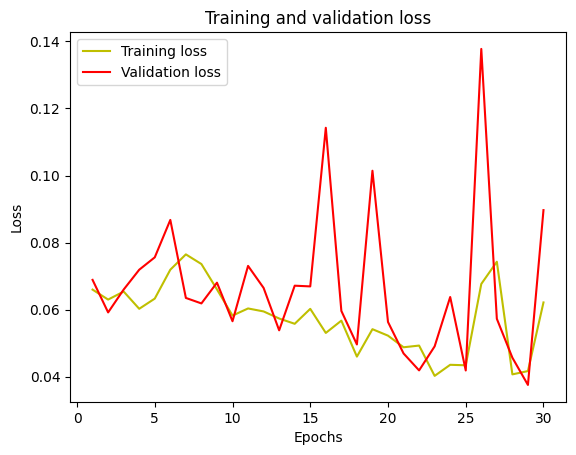

In [22]:
# -----------------------------------------------------------------
# 5. 모델 평가 및 시각화 (변경 없음)
# -----------------------------------------------------------------

# 손실 그래프
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

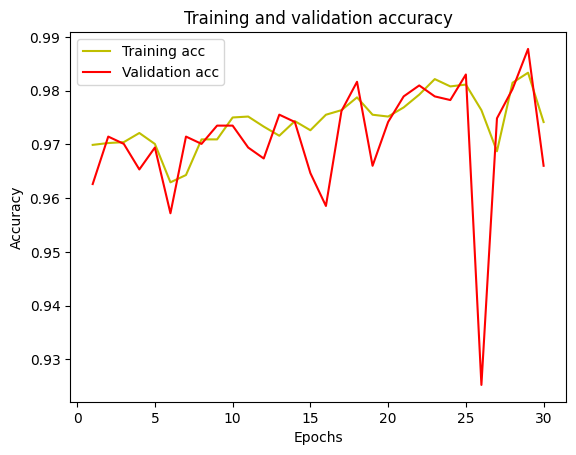

In [23]:
# 정확도 그래프
acc = model_history.history['accuracy']
val_acc = model_history.history['val_accuracy']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [24]:
# -----------------------------------------------------------------
# 6. 최종 예측 및 혼동 행렬 (변경 없음)
# -----------------------------------------------------------------
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [25]:
# 예측 (단일 입력)
pred_probabilities = cnn_lstm_model.predict(testX) # 단일 입력
pred = np.argmax(pred_probabilities, axis=-1)

93/93 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step


[[469   6  21   0   0   0]
 [  1 460   8   2   0   0]
 [  0  15 405   0   0   0]
 [  0  23   0 376  91   1]
 [  0   1   0  55 476   0]
 [  0  27   0   0   0 510]]
0.9148286392941974
              precision    recall  f1-score   support

           0       1.00      0.95      0.97       496
           1       0.86      0.98      0.92       471
           2       0.93      0.96      0.95       420
           3       0.87      0.77      0.81       491
           4       0.84      0.89      0.87       532
           5       1.00      0.95      0.97       537

    accuracy                           0.91      2947
   macro avg       0.92      0.92      0.92      2947
weighted avg       0.92      0.91      0.91      2947



<Axes: >

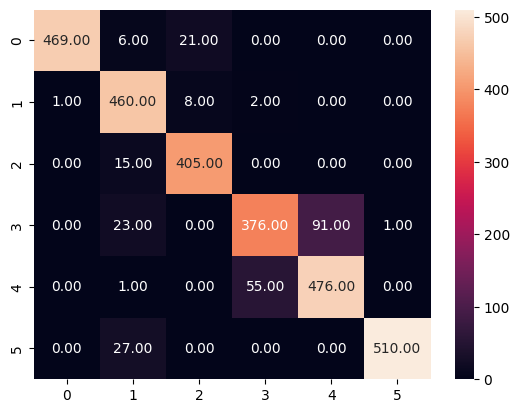

In [26]:
# 평가
cm = confusion_matrix(testy, pred)
print(cm)
print(accuracy_score(testy, pred))
print(classification_report(testy, pred))
sns.heatmap(cm, annot=True, fmt='.2f')